# Task
Find the actual component values of the bandpass filter in fig. 1.

1. Compare the measured response voltage $U_a$ with the predicted response voltage under nominal component values.
2. Determine the root mean square error (rmse). 
3. Calculate the rmse for different values of $L$ and $C$.
4. Minimize the rmse function to find the actual component values.

![Circuit Diagramm](circuit.png)

In [174]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sci
from math import pi
import cmath

# Get Data

In [175]:
COIL=9e-3
CAPACITOR=1000e-6

def load_measured_data(filename):    
    # import measured data from file and return DataFrame
    with np.load(filename) as file:
        return pd.DataFrame({"time" : file["t_mess"], "measured" : file["u_a_mess"]})

def predicted_voltage(coil, capacitor):
    # return calculated voltage by creating LTI System with given parameters
    RESISTOR=20
    INPUT_VOLTAGE = 2

    numerator=[1/(RESISTOR*capacitor), 0]
    denominator=[1, 1/(RESISTOR*capacitor), 1/(coil*capacitor)]
    transfer_function=sci.signal.TransferFunction(numerator, denominator)

    return INPUT_VOLTAGE*sci.signal.step(transfer_function, T=u_a["time"])[1]

u_a = load_measured_data("messwerte.npz")
u_a["predicted"] = predicted_voltage(COIL, CAPACITOR) # append dataframe with predicted values

# Analysis
## Plot Expected and Measured Data

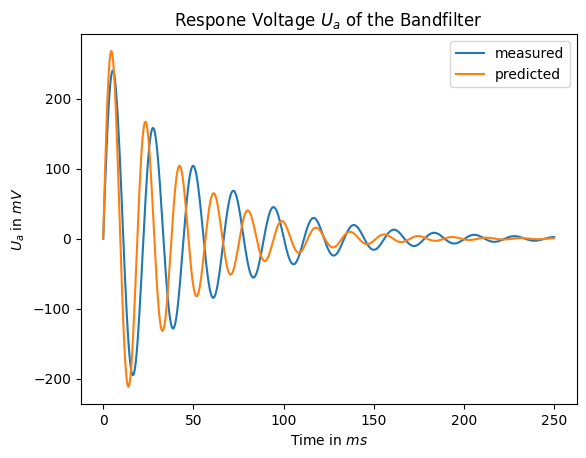

In [176]:
plt.plot(u_a["time"]*10**3, u_a["measured"]*10**3, label="measured")
plt.plot(u_a["time"]*10**3, u_a["predicted"]*10**3, label='predicted')

plt.title("Respone Voltage $U_a$ of the Bandfilter")
plt.xlabel("Time in $ms$")
plt.ylabel("$U_a$ in $mV$")
plt.legend()

plt.show()

## Calculate Root Mean Square Error

In [177]:
def root_mean_square_error(predicted): 
    # Calculate the root mean square error of 2 1D arrays
    return np.round(np.sqrt(1/len(predicted) * np.sum(np.square(np.subtract(predicted, u_a["measured"])))), 2)

rsme = root_mean_square_error(u_a["predicted"])
print(f"RSME with nominal values: {rsme*10**3} mV")

RSME with nominal values: 60.0 mV


# Find best/true values for Coil and Capacitor

## Create RMSE Grid

In [178]:
STEPS = 20
COIL_LOWER = 7e-3
COIL_UPPER = 12e-3
CAPACITOR_LOWER = 9 * 100e-6
CAPACITOR_UPPER = 16 * 100e-6

def resistor_list(lower, upper, steps):
    return np.linspace(lower, upper, steps)

def rsme_grid(coil_list, capacitor_list):
    # find rsme for each coil and capacitor values
    rsme = np.zeros((len(coil_list), len(capacitor_list)))   # reserve array space

    for i in range(len(coil_list)):
        for j in range(len(capacitor_list)):
            rsme[i][j] = root_mean_square_error(predicted_voltage(coil_list[i], capacitor_list[j]))

    return rsme

coil_list = resistor_list(COIL_LOWER, COIL_UPPER, STEPS)
capacitor_list = resistor_list(CAPACITOR_LOWER, CAPACITOR_UPPER, STEPS)

Z = rsme_grid(coil_list, capacitor_list)

## Plot RSME Contour and Surface

C:\Users\janho\AppData\Local\Temp\ipykernel_19580\3781228332.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(coil_list*10**3, capacitor_list*10**3, Z*10**3, label="RSME")


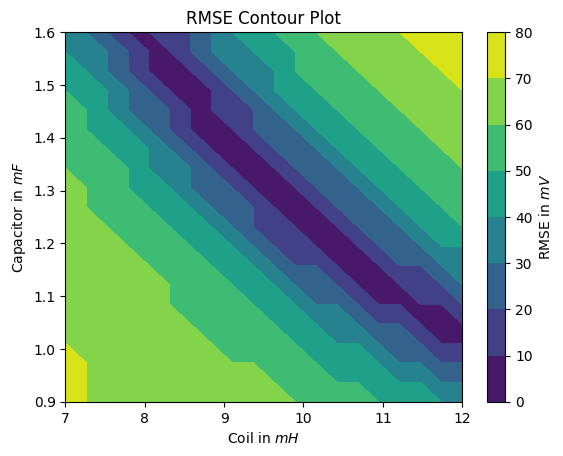

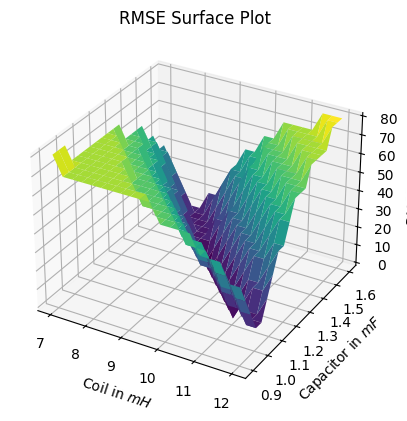

In [179]:
# Create Contour Plot
plt.contourf(coil_list*10**3, capacitor_list*10**3, Z*10**3, label="RSME")
plt.title('RMSE Contour Plot')
plt.xlabel('Coil in $mH$')
plt.ylabel('Capacitor in $mF$')
plt.colorbar(label='RMSE in $mV$')
plt.show()

x,y = np.meshgrid(coil_list, capacitor_list)

# Create a 3D plot
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(x*10**3, y*10**3, Z*10**3, cmap='viridis')
plt.title('RMSE Surface Plot')
ax.set_xlabel('Coil in $mH$')
ax.set_ylabel('Capacitor in $mF$')
ax.set_zlabel('RMSE in mV')
plt.show()

## Minimize rsme with variable parameters

In [180]:
def rsme_singel_input(params):
    # redefine rms function to work with a single input variable.
    # params is a 1d array. first element is the coil, second element is the capacitor.

    RESISTOR=20
    INPUT_VOLTAGE = 2

    numerator=[1/(RESISTOR*params[1]), 0]
    denominator=[1, 1/(RESISTOR*params[1]), 1/(params[0]*params[1])]
    transfer_function=sci.signal.TransferFunction(numerator, denominator)

    voltage =  INPUT_VOLTAGE*sci.signal.step(transfer_function, T=u_a["time"])[1]

    return root_mean_square_error(voltage)

INITIAL_GUESS = [COIL, CAPACITOR]
# INITIAL_GUESS = [0.01, 0.0013]
BOUNDS = [(COIL_LOWER, COIL_UPPER),(CAPACITOR_LOWER, CAPACITOR_UPPER)]

# ! rsme function retuns discrete values. Thereby minimize can't calculate a gradient. 
result = sci.optimize.dual_annealing(rsme_singel_input, BOUNDS, x0=INITIAL_GUESS)
# result = sci.optimize.minimize(rsme_singel_input, initial_guess, tol = 1e-15)
# print(result)

best_coil, best_capacitor = np.round(result.x, 5)
min_rmse = np.round(result.fun,5)

print(f"True Coil:\t{best_coil*10**3} mH ")
print(f"True Capacitor:\t{best_capacitor*10**3} mF")
print(f"Minimum RMSE:\t{min_rmse*10**3} mV")

True Coil:	8.71 mH 
True Capacitor:	1.4300000000000002 mF
Minimum RMSE:	0.0 mV


# Find all possible parameters so that $RSME$ = 0

## Find Default Frequency with Fast Fourier Transformation

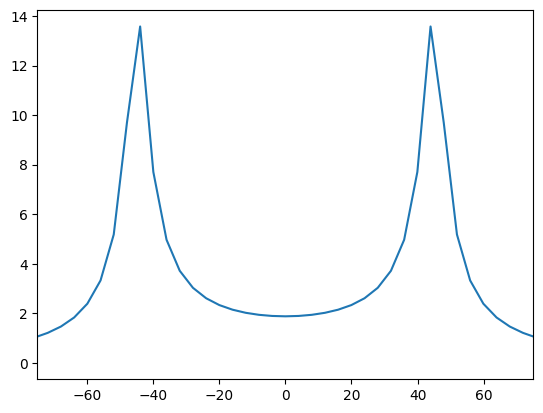

[ 1.87460071+3.40005801e-16j  1.88921115-2.40208139e-02j
  1.93441102-5.03122641e-02j  2.01463173-8.17154154e-02j
  2.13849383-1.22497301e-01j  2.32129288-1.80025250e-01j
  2.59028193-2.68644336e-01j  2.99646502-4.20097932e-01j
  3.64302954-7.16957239e-01j  4.7554648 -1.42899719e+00j
  6.71090485-3.77935157e+00j  4.62122632-1.27672561e+01j
 -6.69952609-7.00516617e+00j -4.71748123-2.13426943e+00j
 -3.18950963-9.31662201e-01j -2.3294206 -5.04823184e-01j
 -1.80037604-3.10492684e-01j -1.44760476-2.07115895e-01j
 -1.19779659-1.46083350e-01j -1.01276735-1.07279086e-01j
 -0.87091055-8.12077980e-02j -0.75915741-6.29293081e-02j
 -0.66916879-4.96737946e-02j -0.59538689-3.97935640e-02j
 -0.53397224-3.22602253e-02j -0.48219156-2.64059102e-02j
 -0.43804876-2.17821592e-02j -0.40005393-1.80791518e-02j
 -0.36707369-1.50775331e-02j -0.33823145-1.26186474e-02j
 -0.31283923-1.05855691e-02j -0.29035003-8.89068516e-03j
 -0.27032384-7.46736816e-03j -0.25240301-6.26427357e-03j
 -0.23629405-5.24135833e-03j -0

In [187]:
fourier = np.fft.fft(u_a["measured"])
dt = u_a["time"][1] - u_a["time"][0]
n = u_a["time"].size
frequency = np.fft.fftfreq(n, d=dt)
plt.plot(np.fft.fftshift(frequency), np.fft.fftshift(abs(fourier)))
plt.xlim(-75, 75)
plt.show()
print(fourier)

# peaks_index, properties = sci.signal.find_peaks(np.abs(fourier))
# frequency_max = frequency[peaks_index[1]]
# print(peaks_index)
# print(frequency_max)
# peaks_index, properties = sci.signal.find_peaks(np.abs(fourier))
# print('Positions and magnitude of frequency peaks:')
# [print("%4.4f    \t %3.4f" %(fourier[peaks_index[i]], )) for i in range(len(peaks_index))]
# properties['peak_heights'][i]

## Model RSME for known optimal Capacitor and Coil Values

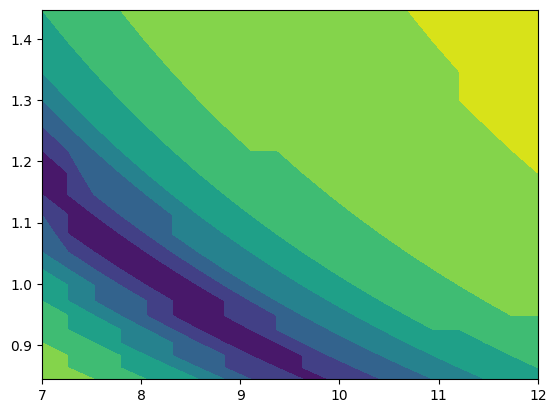

In [189]:
def capacitor_best(coil):
    # misses imaginary unit in nominator
    capacitor = 0.0000101321/coil 
    # - 0.00841627 * i
    return capacitor

capacitor_best = capacitor_best(coil_list)

# Z_min_list = root_mean_square_error(predicted_voltage(coil_list, capacitor_variable_list))
rsme_var_coil = rsme_grid(coil_list, capacitor_best)

plt.contourf(coil_list*10**3, capacitor_best*10**3, rsme_var_coil*10**3)

# Closing Notes

The RSME function is minimal when the calculted voltage is (almost) identical to the measured voltage. The coordinates of the global minimum are the true hardware parameters of C and L.

This is true of for all pairs of C and L that produce the same transferfunction  